In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import os, csv
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Define the CNN architecture

In [25]:
class ScaleClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ScaleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 8 * 8, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Create a custom dataset class

In [26]:
class ScaleDataset(Dataset):
    def __init__(self, csv_file=None, root_dir=None, transform=None):
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.transform = transform

        if csv_file is not None:
            self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data) if self.csv_file is not None else len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if self.csv_file is not None:
            img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
            label = self.data.iloc[idx, 1]
        else:
            img_name = os.path.join(self.root_dir, os.listdir(self.root_dir)[idx])
            label = -1  # Placeholder label for test dataset

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

## Load and preprocessing the data

In [27]:
# Define paths and parameters
train_csv_file = "train_truth.csv"
train_data_dir = "music_train"
test_data_dir = "music_test"
batch_size = 10
num_classes = 88
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for data augmentation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create training dataset and data loader
train_dataset = ScaleDataset(train_csv_file, train_data_dir, transform=transform)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create test dataset without labels
test_dataset = ScaleDataset(csv_file=None, root_dir=test_data_dir, transform=transform)

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
print(device)

cpu


## Train the model 

Epoch 1/7: Train Loss: 4.1692, Train Acc: 0.0457, Val Loss: 3.0875, Val Acc: 0.2158
Epoch 2/7: Train Loss: 1.9616, Train Acc: 0.4297, Val Loss: 1.2578, Val Acc: 0.6035
Epoch 3/7: Train Loss: 0.7422, Train Acc: 0.7825, Val Loss: 0.4755, Val Acc: 0.8684
Epoch 4/7: Train Loss: 0.2929, Train Acc: 0.9310, Val Loss: 0.2072, Val Acc: 0.9526
Epoch 5/7: Train Loss: 0.1248, Train Acc: 0.9763, Val Loss: 0.1130, Val Acc: 0.9754
Epoch 6/7: Train Loss: 0.0662, Train Acc: 0.9925, Val Loss: 0.0849, Val Acc: 0.9789
Epoch 7/7: Train Loss: 0.0385, Train Acc: 0.9956, Val Loss: 0.0290, Val Acc: 0.9982


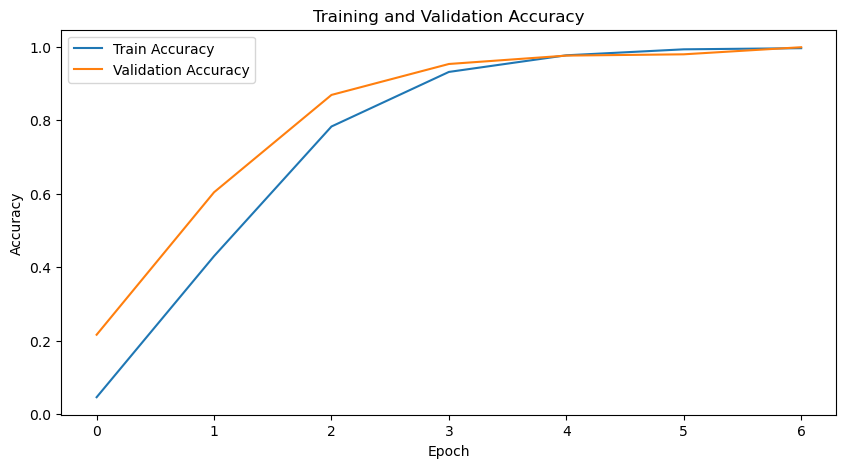

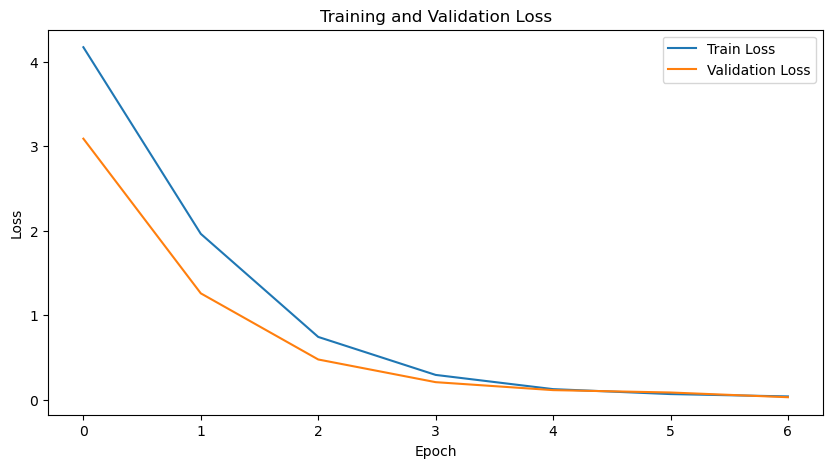

In [6]:
# Initialize the model
#device = torch.device("cpu")
model = ScaleClassifier(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 7
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    train_correct = 0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_dataset)
    train_acc = train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_dataset)
        val_acc = val_correct / len(val_dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'model.pth')

In [35]:
# Load the saved model
model = ScaleClassifier(num_classes).to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()

# Make predictions on the test dataset
with torch.no_grad():
    # Define transformations for data augmentation
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    folder_path = "music_test"
    csv_file = "output.csv"
    
    #get the list of the filenames in the folder
    file_list = os.listdir(folder_path)
    
    with open(csv_file, "w", newline="") as file:
        writer = csv.writer(file)
        #write the hearder row
        writer.writerow(['filename', 'category'])
        
        for filename in file_list:
            image_path = folder_path+'/'+filename
            image = Image.open(image_path).convert("RGB")
            processed_image = transform(image)
            processed_image = processed_image.unsqueeze(0)  # Add batch dimension
            output = model(processed_image)
            predicted_index = np.argmax(output, axis=1)
            value = predicted_index.item()
            
            writer.writerow([filename, value])
    print(f"File list saved to {csv_file}")

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 3

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 3